# Dependencies and notebook settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
from IPython.core.display import display, HTML
import ngboost
from sklearn.tree import DecisionTreeRegressor
from multiprocessing import Pool
import os
from mp_cv import final_model_ver2
from var_test import *

display(HTML("<style>.container { width:90% !important; }</style>"))
plt.style.use("ggplot")
mpl.rcParams["figure.dpi"] = 100
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

# Data import 

In [2]:
df = pd.read_parquet("../dataset/spx_ngboost_final_dataset.parquet")
df = df.tail(4*252)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2016-09-29 to 2020-09-30
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rr                  1008 non-null   float64
 1   Volume_L1           1008 non-null   float64
 2   OBV_L1              1008 non-null   float64
 3   Volume_L2           1008 non-null   float64
 4   EMA_W_L1            1008 non-null   float64
 5   Open_stationary_L3  1008 non-null   float64
 6   MA_L1               1008 non-null   float64
 7   EMA_L1              1008 non-null   float64
 8   MA_2_L3             1008 non-null   float64
 9   MA_W_L2             1008 non-null   float64
 10  MA_W_L3             1008 non-null   float64
 11  Volume_L3           1008 non-null   float64
 12  ATR_L2              1008 non-null   float64
 13  OBV_L3              1008 non-null   float64
 14  EMA_W_L3            1008 non-null   float64
 15  ADOSC_L3            1008 non-null   f

In [3]:
features = df.columns.tolist()
features.remove("rr")

# NGBoost models estimation and VaR calculation

In the second modeling approach I will predict VaR using following formula (quasi GARCH approach): VaR = model.forecasted.mean + model.forecasted.variance * (model.standardized_residuals).

In [4]:
NGBoost_all = list()

params = [["Laplace",0.01,100],
          ["Laplace",0.01,250],
          ["Laplace",0.01,500],
          ["T",0.01,100],
          ["T",0.01,250],
          ["T",0.1,250]]

if __name__ ==  '__main__': 
    for j in tqdm(params):
        train_test_setup = list()
        for i in range(0,252):
            train_test_setup.append([df.iloc[i : i + 252 * 3], df.iloc[i + 252 * 3 : i + 252 * 3 + 1], j[0], j[1], j[2]])
        num_proces = os.cpu_count()
        p = Pool(processes = num_proces)
        output = p.map(final_model_ver2, train_test_setup)
        NGBoost_all.append(output)
        p.close()
        p.join()

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [18:10<00:00, 181.67s/it]


In [5]:
results_dict = {
    "rr":df.tail(252).rr.values,
    "NGBoostDistLaplaceEta001It100_1": np.array(NGBoost_all[0])[:,0].tolist(),
    "NGBoostDistLaplaceEta001It250_1": np.array(NGBoost_all[1])[:,0].tolist(),
    "NGBoostDistLaplaceEta001It500_1": np.array(NGBoost_all[2])[:,0].tolist(),
    "NGBoostDistLaplaceEta001It100_25": np.array(NGBoost_all[0])[:,1].tolist(),
    "NGBoostDistLaplaceEta001It250_25": np.array(NGBoost_all[1])[:,1].tolist(),
    "NGBoostDistLaplaceEta001It500_25": np.array(NGBoost_all[2])[:,1].tolist(),

    "NGBoostDistTEta001It100_1": np.array(NGBoost_all[3])[:,0].tolist(),
    "NGBoostDistTEta001It250_1": np.array(NGBoost_all[4])[:,0].tolist(),
    "NGBoostDistTEta01It250_1": np.array(NGBoost_all[5])[:,0].tolist(),
    "NGBoostDistTEta001It100_25": np.array(NGBoost_all[3])[:,1].tolist(),
    "NGBoostDistTEta001It250_25": np.array(NGBoost_all[4])[:,1].tolist(),
    "NGBoostDistTEta01It250_25": np.array(NGBoost_all[5])[:,1].tolist()}

results = pd.DataFrame(results_dict, index = df.tail(252).index)

In [6]:
results.head()

,rr,NGBoostDistLaplaceEta001It100_1,NGBoostDistLaplaceEta001It250_1,NGBoostDistLaplaceEta001It500_1,NGBoostDistLaplaceEta001It100_25,NGBoostDistLaplaceEta001It250_25,NGBoostDistLaplaceEta001It500_25,NGBoostDistTEta001It100_1,NGBoostDistTEta001It250_1,NGBoostDistTEta01It250_1,NGBoostDistTEta001It100_25,NGBoostDistTEta001It250_25,NGBoostDistTEta01It250_25
Date,,,,,,,,,,,,,
2019-10-02,-1.806544,-1.976581,-1.922553,-1.858787,-1.581970,-1.561977,-1.608015,-2.168450,-2.138533,-0.917951,-1.580219,-1.565102,-0.650546
2019-10-03,0.794038,-2.581481,-2.654294,-2.306559,-2.077872,-2.105699,-1.964899,-3.766505,-4.194755,-2.108532,-2.827646,-3.263920,-1.771502
2019-10-04,1.411674,-2.690249,-3.091963,-2.697462,-2.207951,-2.512363,-2.229599,-2.811273,-2.970160,-1.707559,-2.159077,-2.279026,-1.225575
2019-10-07,-0.448836,-2.552965,-1.873480,-1.360946,-2.056112,-1.455239,-1.055065,-2.826787,-2.474329,-0.261065,-2.203539,-1.838962,0.024097
2019-10-08,-1.568317,-2.470496,-2.444732,-2.390201,-2.005921,-2.036351,-2.031238,-2.624607,-2.736122,-2.356962,-2.044392,-2.156892,-1.665755


In [7]:
results.tail()

,rr,NGBoostDistLaplaceEta001It100_1,NGBoostDistLaplaceEta001It250_1,NGBoostDistLaplaceEta001It500_1,NGBoostDistLaplaceEta001It100_25,NGBoostDistLaplaceEta001It250_25,NGBoostDistLaplaceEta001It500_25,NGBoostDistTEta001It100_1,NGBoostDistTEta001It250_1,NGBoostDistTEta01It250_1,NGBoostDistTEta001It100_25,NGBoostDistTEta001It250_25,NGBoostDistTEta01It250_25
Date,,,,,,,,,,,,,
2020-09-24,0.298295,-3.384966,-3.541792,-3.669311,-2.760316,-3.043278,-3.102055,-3.260630,-3.935347,-3.295684,-2.633763,-2.865194,-2.184248
2020-09-25,1.585048,-3.038784,-3.070875,-2.702415,-2.408087,-2.723864,-2.382093,-3.302961,-3.597271,-3.415809,-2.520686,-2.565817,-2.660222
2020-09-28,1.598215,-2.596211,-2.723662,-2.458671,-2.164844,-2.164668,-2.051096,-3.104855,-3.211592,-1.347252,-2.481314,-2.126100,-1.024204
2020-09-29,-0.482424,-2.987221,-2.543333,-2.249240,-2.182867,-2.197358,-1.859250,-3.139225,-2.921592,-1.619886,-2.464468,-2.122592,-1.179454
2020-09-30,0.821983,-2.740536,-2.348533,-2.333270,-2.052950,-1.913587,-1.967658,-3.137222,-2.806862,-2.629621,-2.362521,-2.048542,-2.050835


# Results backtesting

In [8]:
models = set([i.split("_")[0] for i in results_dict.keys()])
models.remove("rr")
alphas = ["1", "25"]

## Visualization -  realization of rates of return vs VaR forecasts

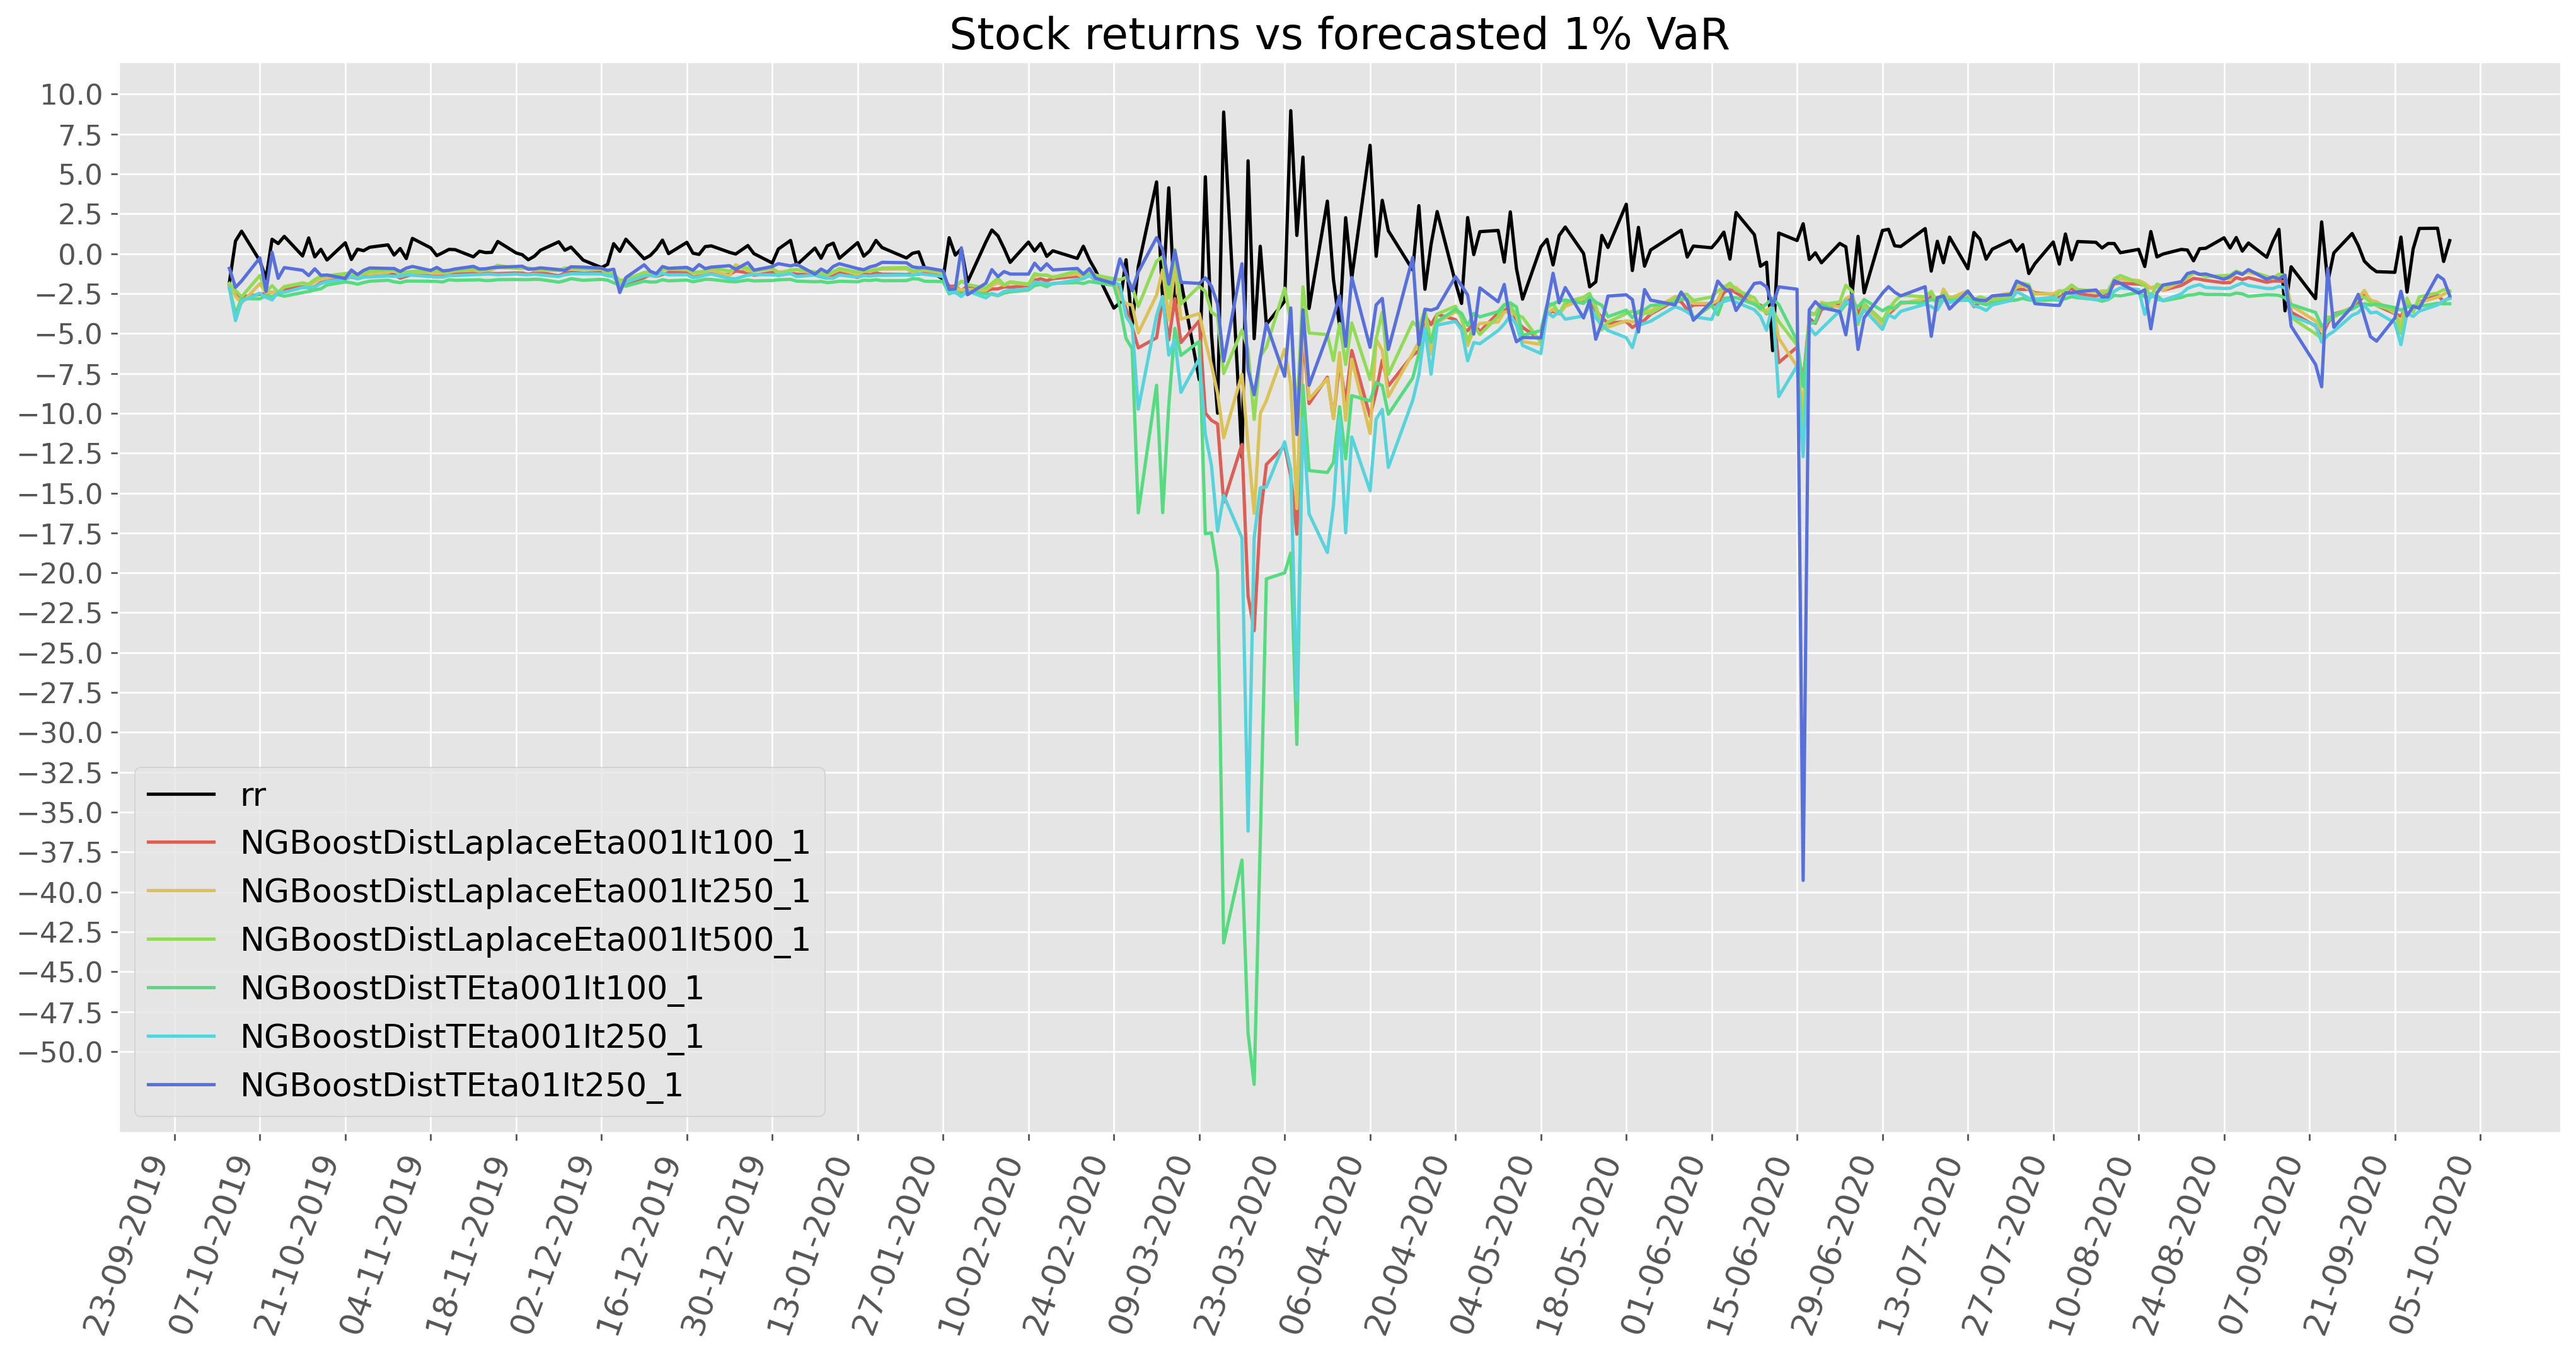

In [21]:
viz1_df = results.loc[:,(results.columns.str.endswith(("1","rr")))]

mpl.rcParams["figure.dpi"] = 250
plt.rcParams["figure.figsize"] = (20, 10)
cols = list(sns.color_palette("hls", 8))
cols.insert(0,(0,0,0))
ax = viz1_df.plot(color = cols)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()
plt.title("Stock returns vs forecasted 1% VaR", fontsize=20)
plt.xlabel("")
plt.legend(fontsize=15)
plt.xticks(rotation=70, fontsize=15)
plt.yticks(np.arange(-50,12.5, 2.5),fontsize=13)
plt.show()

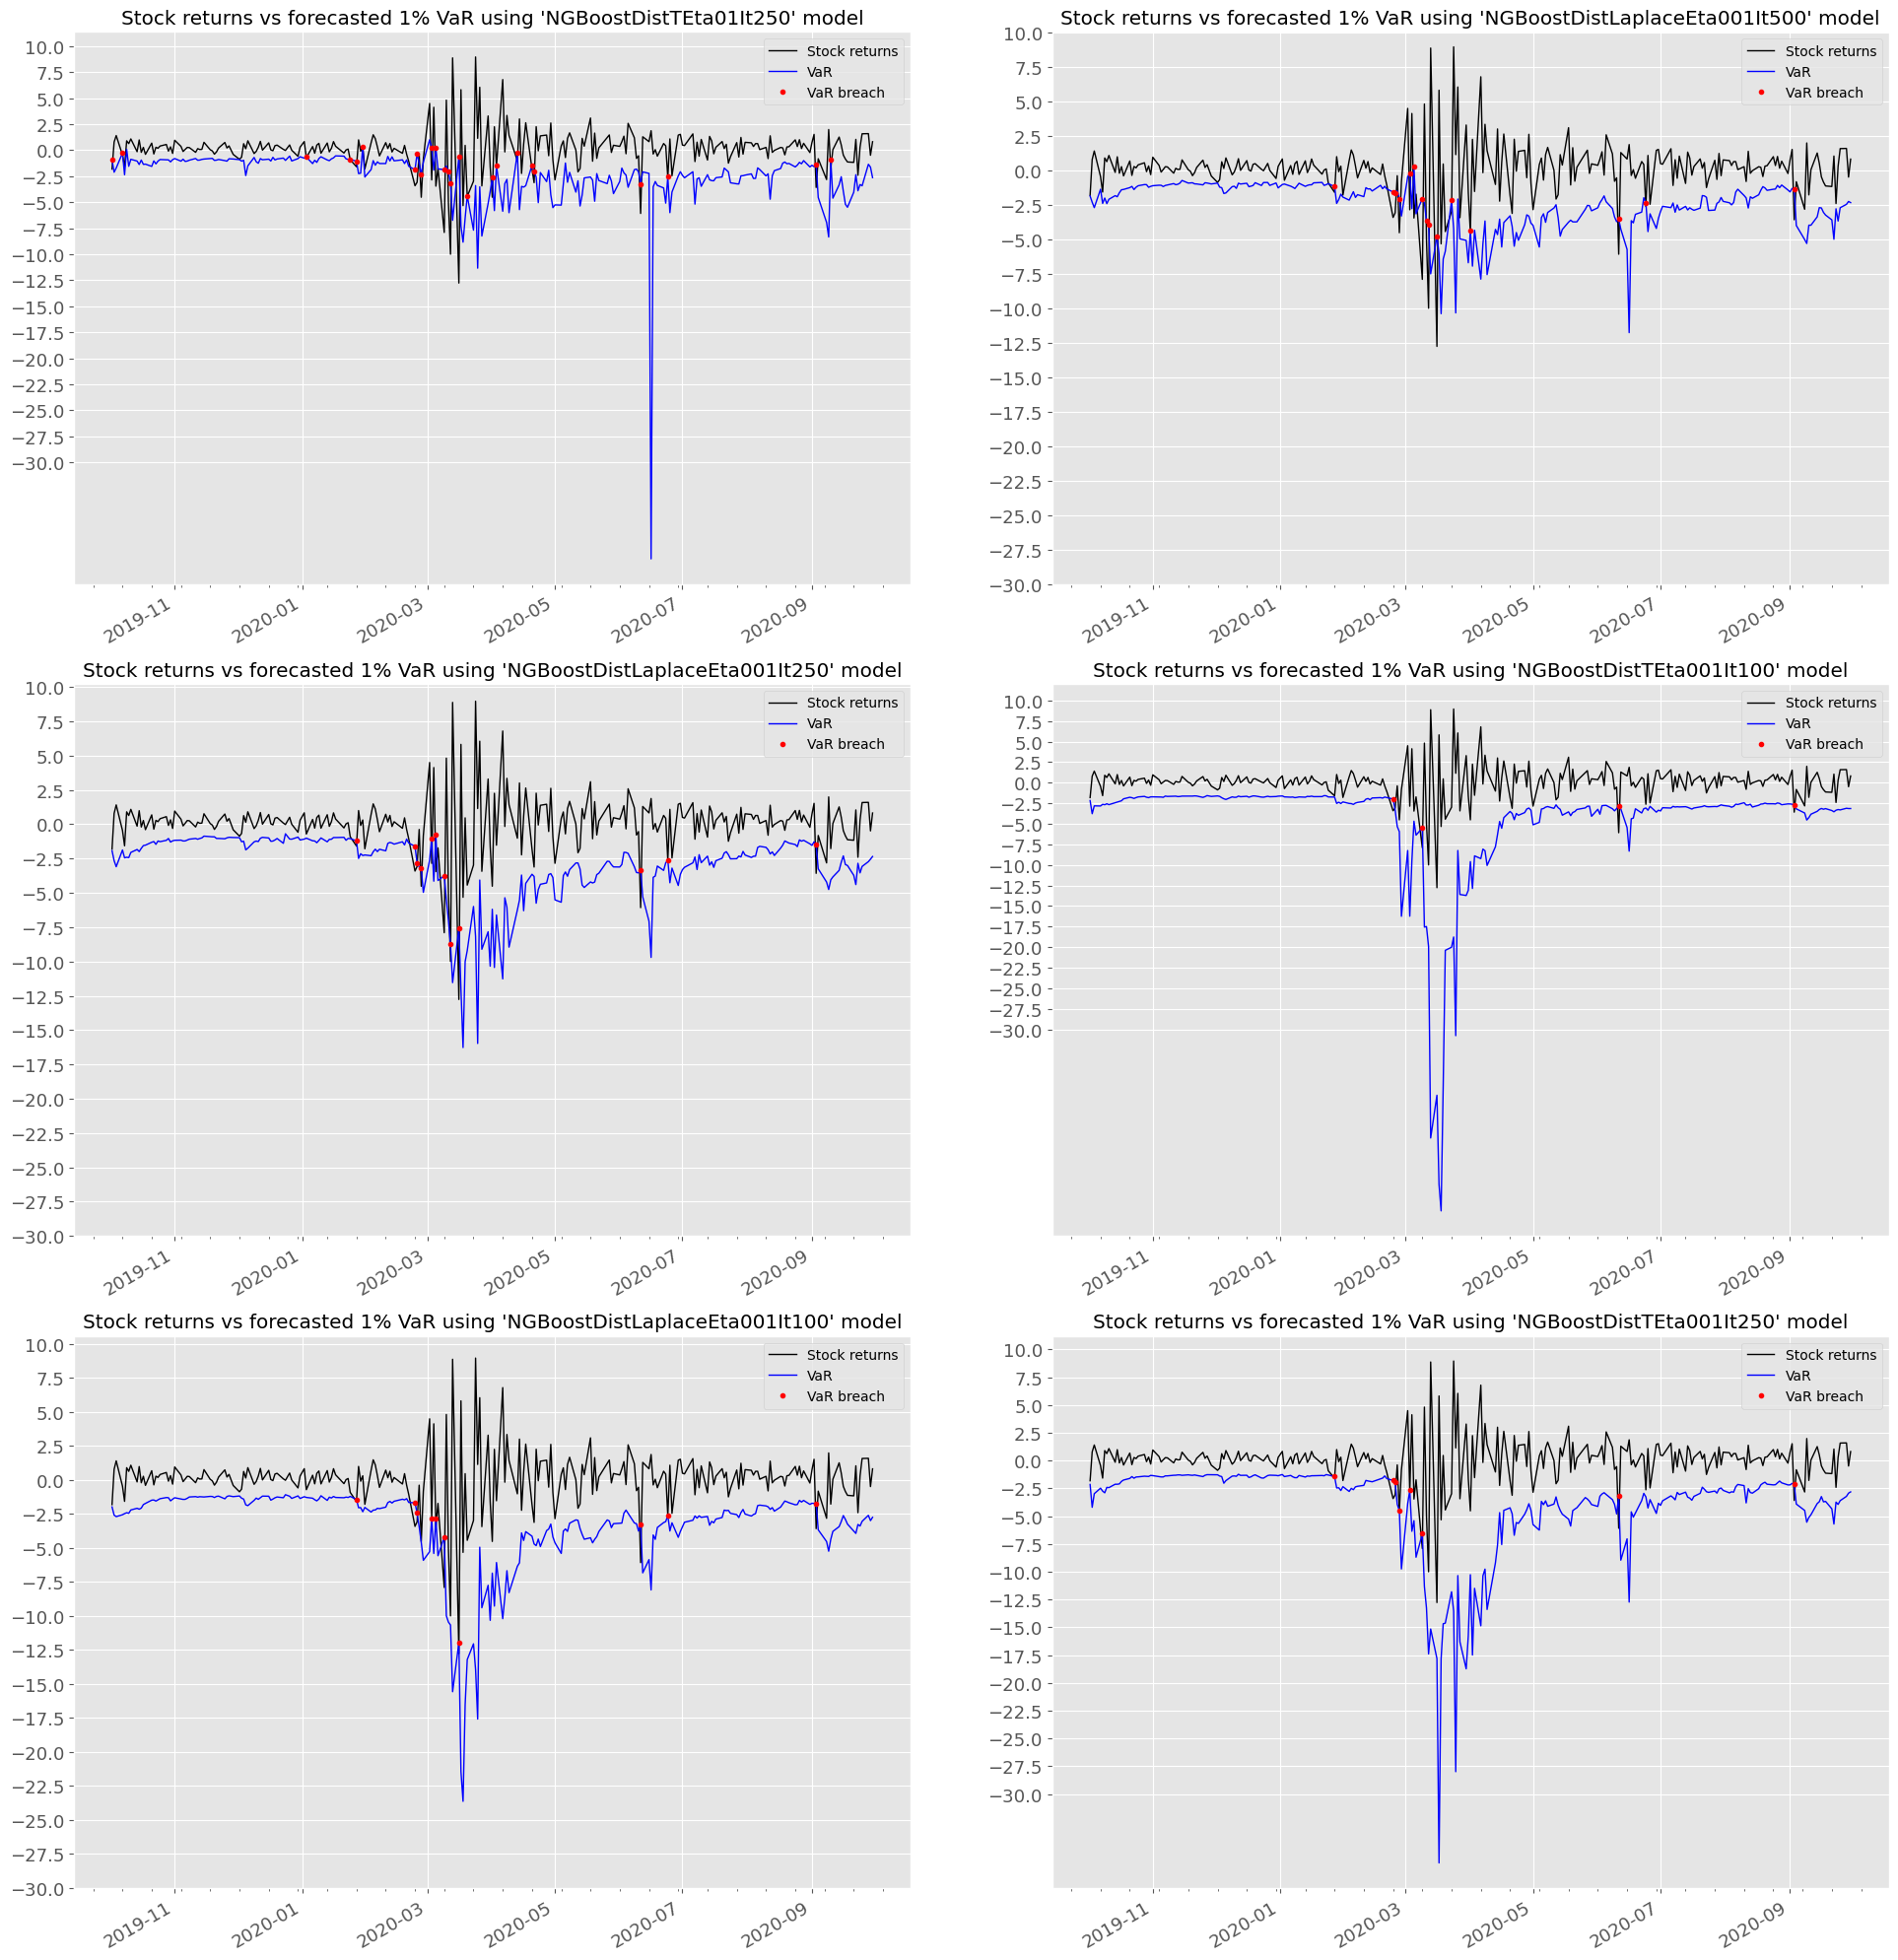

In [10]:
models_list = list(models)

mpl.rcParams["figure.dpi"] = 100
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
for i, ax in zip(range(0,6), axes.flat):
    name = models_list[i] + "_1"
    viz1_df["rr"].plot(color='black', linewidth=1, ax=ax)
    viz1_df[name].plot(color='blue', linewidth=1, ax=ax)
    ax.plot(viz1_df[name][viz1_df["rr"] < viz1_df[name]], color='red', linewidth=0, marker='.')
    ax.set_xlabel("")
    name_plot = "Stock returns vs forecasted 1% VaR using '" + name.split("_")[0] + "' model"
    ax.set_title(name_plot)
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_yticks(np.arange(-30,12.5, 2.5))
    ax.legend(["Stock returns","VaR","VaR breach"])
    
fig.tight_layout()
plt.show()

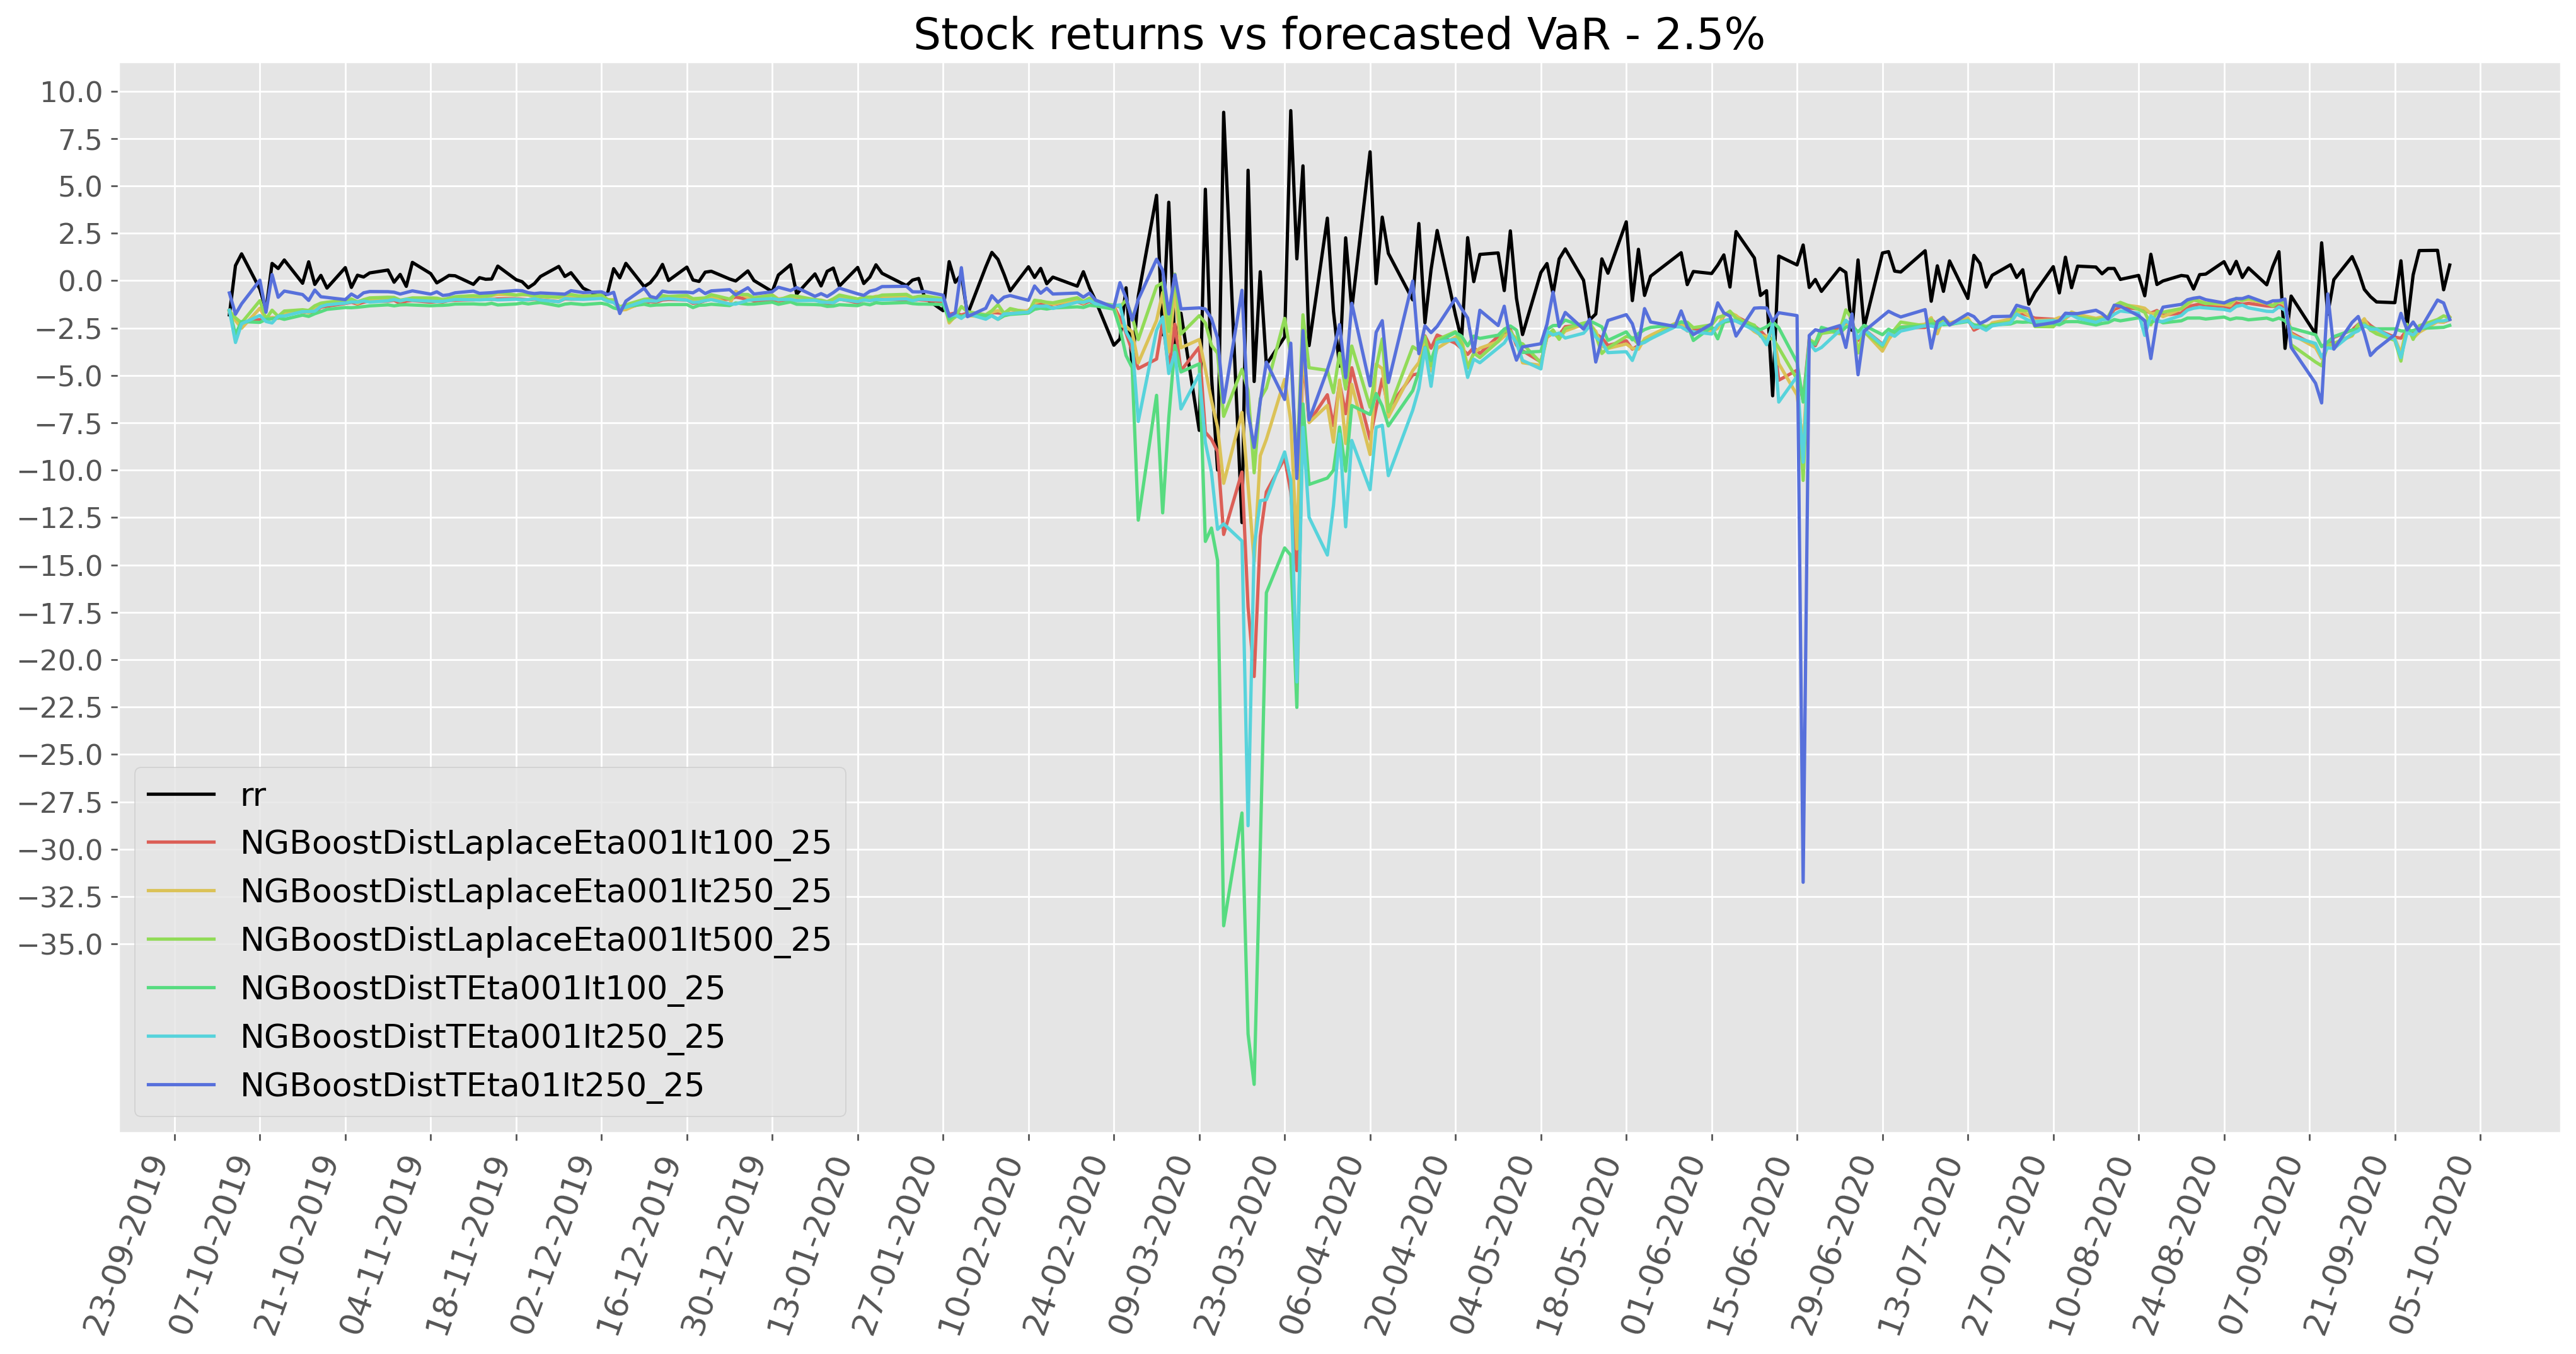

In [22]:
viz25_df = results.loc[:,(results.columns.str.endswith(("25","rr")))]

mpl.rcParams["figure.dpi"] = 250
plt.rcParams["figure.figsize"] = (20, 10)
cols = list(sns.color_palette("hls", 8))
cols.insert(0,(0,0,0))
ax = viz25_df.plot(color = cols)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()
plt.title("Stock returns vs forecasted VaR - 2.5%", fontsize=20)
plt.xlabel("")
plt.legend(fontsize=15)
plt.xticks(rotation=70, fontsize=15)
plt.yticks(np.arange(-35,12.5, 2.5),fontsize=13)
plt.show()

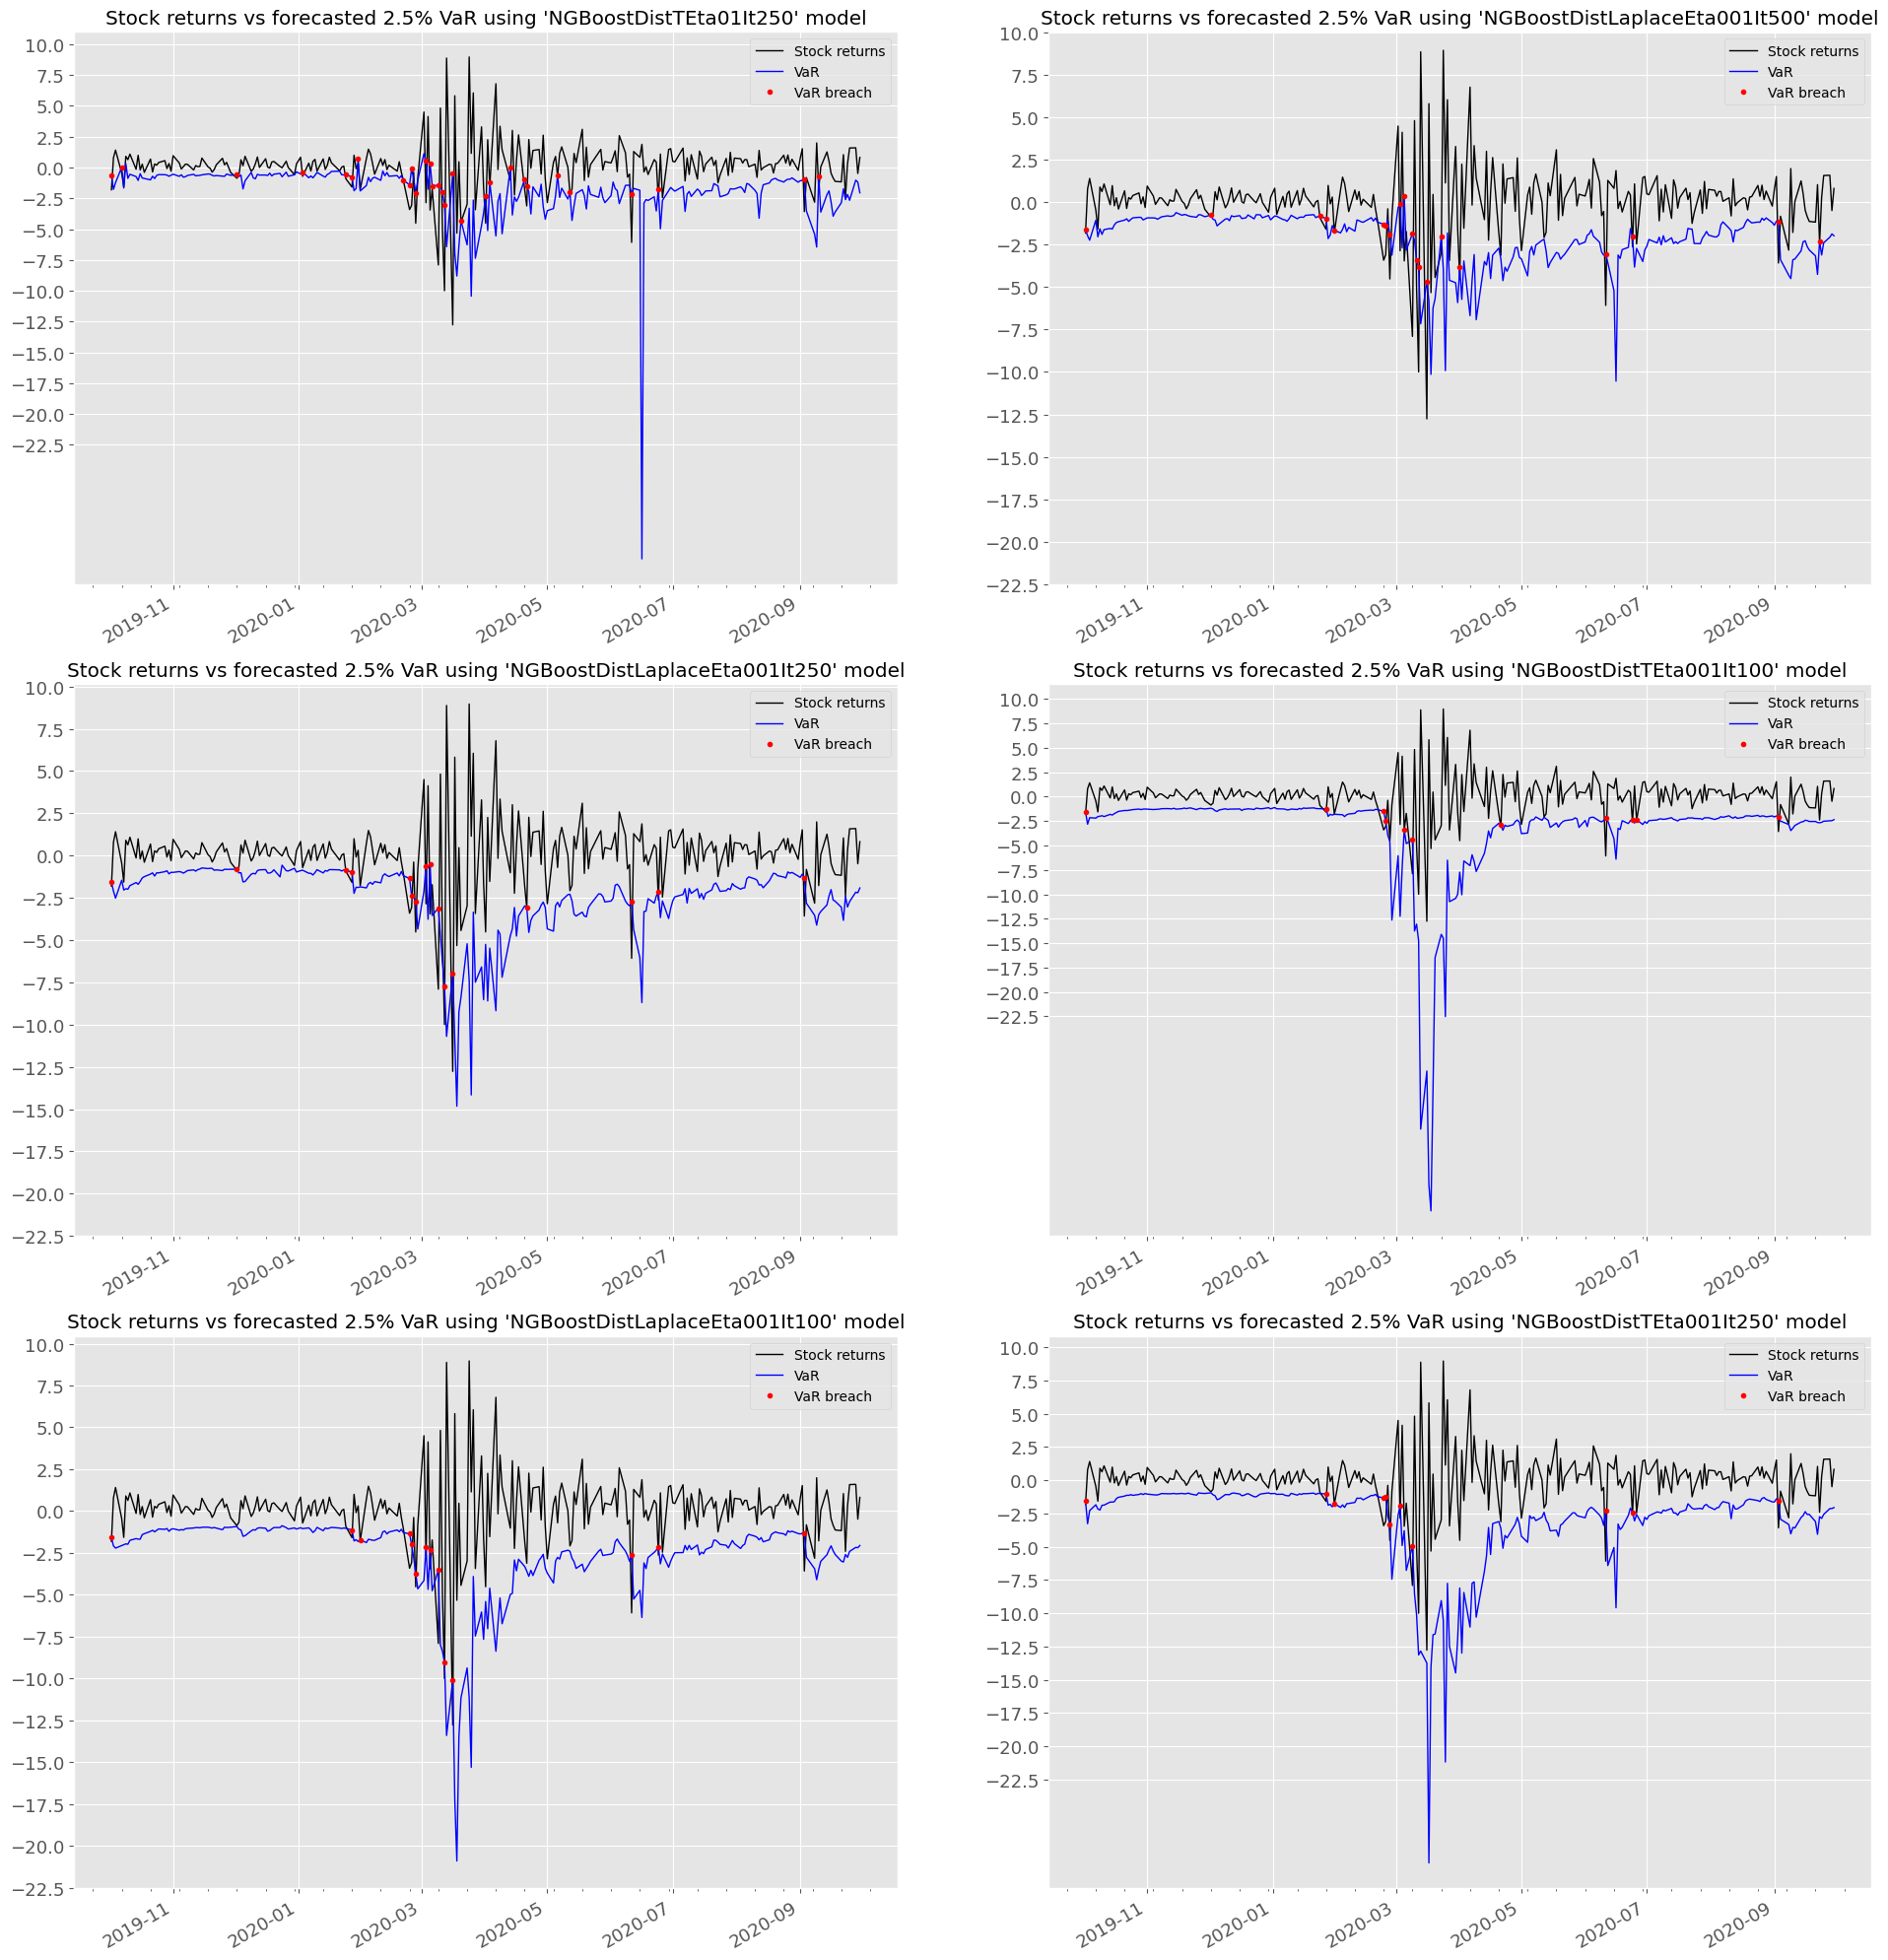

In [12]:
models_list = list(models)

mpl.rcParams["figure.dpi"] = 100
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
for i, ax in zip(range(0,6), axes.flat):
    name = models_list[i] + "_25"
    viz25_df["rr"].plot(color='black', linewidth=1, ax=ax)
    viz25_df[name].plot(color='blue', linewidth=1, ax=ax)
    ax.plot(viz25_df[name][viz25_df["rr"] < viz25_df[name]], color='red', linewidth=0, marker='.')
    ax.set_xlabel("")
    name_plot = "Stock returns vs forecasted 2.5% VaR using '" + name.split("_")[0] + "' model"
    ax.set_title(name_plot)
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_yticks(np.arange(-22.5,12.5, 2.5))
    ax.legend(["Stock returns","VaR","VaR breach"])
    
fig.tight_layout()
plt.show()

## The absolute number and the percentage of exceedances of the VaR level 

In [13]:
output_ex = list()

for i in models:
    for j in alphas:
        name = i + "_" + j
        ex = sum(results[name] > results["rr"])
        j = "2.5" if j == "25" else "1"
        output_ex.append([i,j,ex])

output_ex = pd.DataFrame(output_ex, columns = ["model","pval","exceed"])
output_cross_tab_ex_absolute = pd.pivot_table(output_ex, index = ['model'], columns=['pval'], values=['exceed'])
output_cross_tab_ex_percent = pd.pivot_table(output_ex, index = ['model'], columns=['pval'], values=['exceed'], margins=False, aggfunc='sum')/252*100

In [14]:
display(output_cross_tab_ex_absolute)
display(output_cross_tab_ex_percent)

exceed    
pval                               1 2.5
model                                   
NGBoostDistLaplaceEta001It100     10  14
NGBoostDistLaplaceEta001It250     12  16
NGBoostDistLaplaceEta001It500     15  20
NGBoostDistTEta001It100            4  11
NGBoostDistTEta001It250            8  11
NGBoostDistTEta01It250            25  30

exceed           
pval                                  1        2.5
model                                             
NGBoostDistLaplaceEta001It100  3.968254   5.555556
NGBoostDistLaplaceEta001It250  4.761905   6.349206
NGBoostDistLaplaceEta001It500  5.952381   7.936508
NGBoostDistTEta001It100        1.587302   4.365079
NGBoostDistTEta001It250        3.174603   4.365079
NGBoostDistTEta01It250         9.920635  11.904762

##  Kupiec test (unconditional coverage), Christoffersen test (conditional coverage) and Engle test (dynamic quantile)

In [15]:
output_test = list()

for i in models:
    for j in alphas:
        name = i + "_" + j
        realisation_array = results["rr"].values
        vars_array = results[name].values
        j = "2.5" if j == "25" else "1"
        p = 0.025 if j == "25" else 0.01
        test1 = kupiec_pof(y = pd.DataFrame(realisation_array), y_p = pd.DataFrame(vars_array), p = p)["p-value"]
        test2 = haas_dweibull(y = pd.DataFrame(realisation_array), y_p = pd.DataFrame(vars_array), p = p)["p-value"]
        test3 = christoffersen_ccov(y = pd.DataFrame(realisation_array), y_p = pd.DataFrame(vars_array), p = p)["p-value"]
        test4 = engle_dq (y = pd.DataFrame(realisation_array), y_p = pd.DataFrame(vars_array), p = p, k = 3)["p-value"]
        output_test.append([i,j,test1, test2, test3, test4])

output_test = pd.DataFrame(output_test, columns = ["model","pval","kupiec_pof","haas_dweibull","christoffersen_ccov","engle_dq"])
output_cross_tab_test = pd.pivot_table(output_test, index = ['model'], columns=['pval'], values=['kupiec_pof','haas_dweibull','christoffersen_ccov','engle_dq']).round(3)

In [16]:
output_cross_tab_test

christoffersen_ccov      engle_dq       \
pval                                            1  2.5        1  2.5   
model                                                                  
NGBoostDistLaplaceEta001It100                0.00  0.0    0.000  0.0   
NGBoostDistLaplaceEta001It250                0.00  0.0    0.000  0.0   
NGBoostDistLaplaceEta001It500                0.00  0.0    0.000  0.0   
NGBoostDistTEta001It100                      0.44  0.0    0.869  0.0   
NGBoostDistTEta001It250                      0.00  0.0    0.000  0.0   
NGBoostDistTEta01It250                       0.00  0.0    0.000  0.0   

                              haas_dweibull        kupiec_pof       
pval                                      1    2.5          1  2.5  
model                                                               
NGBoostDistLaplaceEta001It100         0.125  0.010      0.000  0.0  
NGBoostDistLaplaceEta001It250         0.082  0.001      0.000  0.0  
NGBoostDistLaplaceEta001It500         0.018  0.000      0.000  0.0  
NGBoostDistTEta001It100               0.826  0.015      0.388  0.0  
NGBoostDistTEta001It250               0.448  0.034      0.006  0.0  
NGBoostDistTEta01It250                0.000  0.000      0.000  0.0

## Financial provisions

In [17]:
amount = 1e6 #USD
output_prov = list()

for i in models:
    for j in alphas:
        name = i + "_" + j
        prov = sum(abs(results[name].values) * amount)
        j = "2.5" if j == "25" else "1"
        output_prov.append([i,j,prov])

output_prov = pd.DataFrame(output_prov, columns = ["model","pval","prov"])
output_cross_prov = pd.pivot_table(output_prov, index = ['model'], columns=['pval'], values=['prov'])

In [18]:
output_cross_prov

prov              
pval                                      1           2.5
model                                                    
NGBoostDistLaplaceEta001It100  8.503362e+06  6.811374e+06
NGBoostDistLaplaceEta001It250  7.486669e+06  6.294232e+06
NGBoostDistLaplaceEta001It500  6.376864e+06  5.468166e+06
NGBoostDistTEta001It100        1.150421e+07  8.875336e+06
NGBoostDistTEta001It250        1.040267e+07  7.805425e+06
NGBoostDistTEta01It250         6.140006e+06  4.734825e+06

## VaR breach vs  financial provisions

In [19]:
viz_ex_prov_1 = pd.merge(output_cross_prov[('prov',   '1')], output_cross_tab_ex_absolute[('exceed',   '1')], left_index=True, right_index=True)
viz_ex_prov_25 = pd.merge(output_cross_prov[('prov',   '2.5')], output_cross_tab_ex_absolute[('exceed',   '2.5')], left_index=True, right_index=True)

viz_ex_prov_1.columns = ["prov", "exceed"]
viz_ex_prov_25.columns = ["prov", "exceed"]

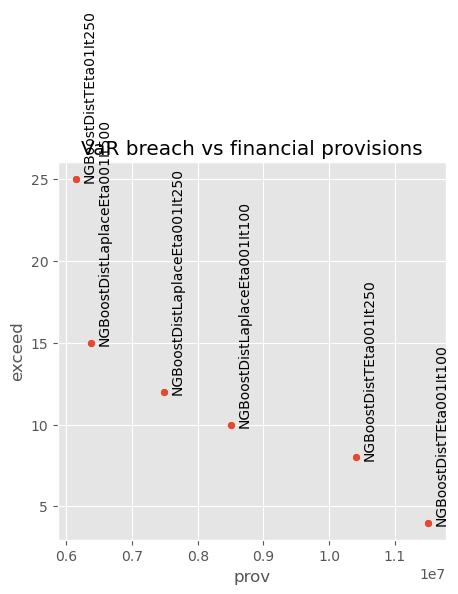

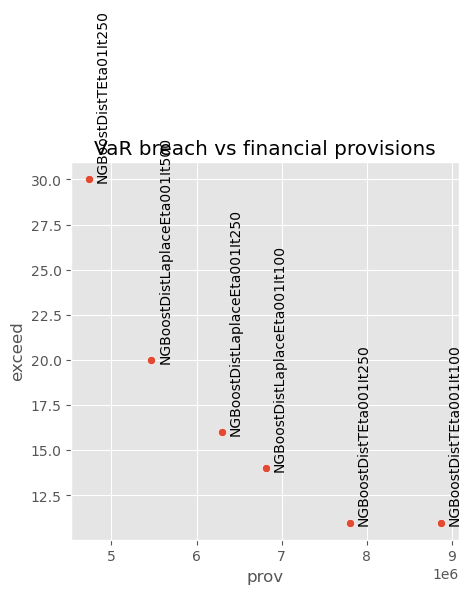

In [20]:
mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (5, 5)
sns.scatterplot(data=viz_ex_prov_1, x="prov", y="exceed")
plt.title("VaR breach vs financial provisions")

for x, y, z in zip(viz_ex_prov_1.prov, viz_ex_prov_1.exceed, viz_ex_prov_1.index):
    label = z
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=90)

plt.show()

mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (5, 5)
sns.scatterplot(data=viz_ex_prov_25, x="prov", y="exceed")
plt.title("VaR breach vs financial provisions")

for x, y, z in zip(viz_ex_prov_25.prov, viz_ex_prov_25.exceed, viz_ex_prov_25.index):
    label = z
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=90)

plt.show()